In [1]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("png")

from data import mat_utils
from data.dataset import Dataset1, Dataset4
from models import baseline

In [2]:
!ls ~/data/BCI

1_EEG_LRhandMI  4_EEG_6StatesMI


## Dataset 1: Left/Right Hand MI
Includes 52 subjects (38 validated subjects with discriminative features), results of physiological and psychological questionnares, EMG Datasets, location of 3D EEG electrodes, and EEGs for non-task related states.

### DS1 File Contents

In [3]:
DATASET1_PATH = os.path.expanduser('~/data/BCI/1_EEG_LRhandMI')
print(DATASET1_PATH)
print(os.listdir(DATASET1_PATH)[:5])

/Users/anna/data/BCI/1_EEG_LRhandMI
['s01.mat', 's15.mat', 's29.mat', 's28.mat', 's14.mat']


In [4]:
subject1_path = os.path.join(DATASET1_PATH, 's38.mat')
mat_utils.print_top_level_keys(subject1_path)

['eeg']


In [5]:
mat_utils.print_key_info(subject1_path, 'eeg')

`eeg` keys: ['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc']
noise                ndarray         shape=(5,) dtype=object
rest                 ndarray         shape=(68, 34048) dtype=float32
srate                int             value=512
movement_left        ndarray         shape=(68, 71680) dtype=float32
movement_right       ndarray         shape=(68, 71680) dtype=float32
movement_event       ndarray         shape=(71680,) dtype=uint8
n_movement_trials    int             value=20
imagery_left         ndarray         shape=(68, 358400) dtype=float32
imagery_right        ndarray         shape=(68, 358400) dtype=float32
n_imagery_trials     int             value=100
frame                ndarray         shape=(2,) dtype=int16
imagery_event        ndarray         shape=(358400,) dtype=uint8
comment

### DS1 Data Examples

In [6]:
ds1 = Dataset1(DATASET1_PATH)
ds1.print_info()

Total subjects: 52
Epoch window: 0.500–2.500 s
Total subject data: 2630.00 MB


In [7]:
ds1_subject38 = ds1.get_subject(38)
ds1_subject38.print_info()

Subject ID: 38
sampling_rate: 512, n_trials: 200, n_channels: 64, n_samples: 1024
X: (200, 64, 1024), Y: (200,)


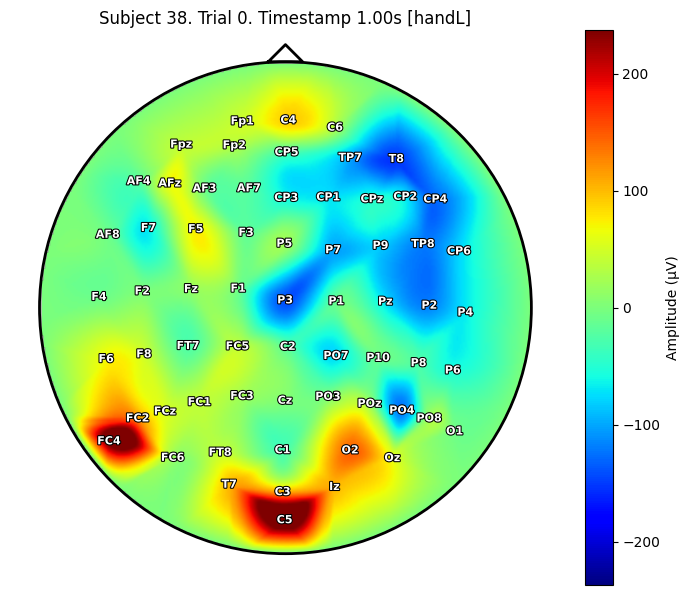

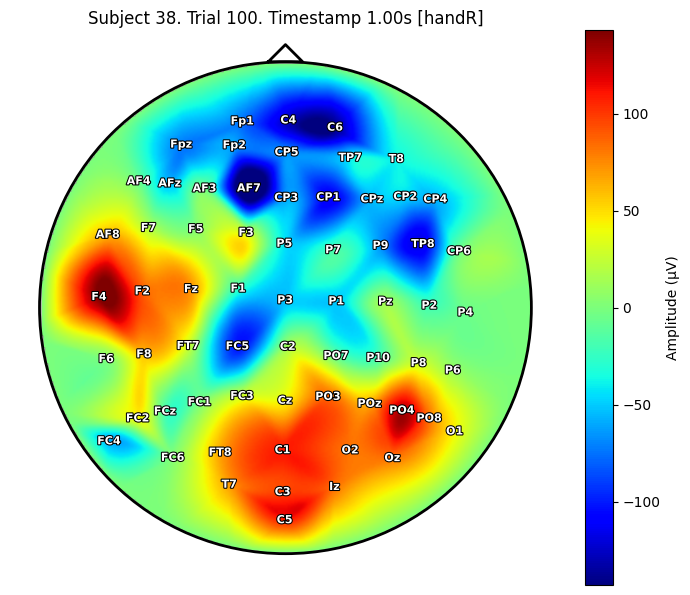

In [8]:
ds1_subject38.plot_head(trial=0, timestamp=1.0, plot_joint=True)

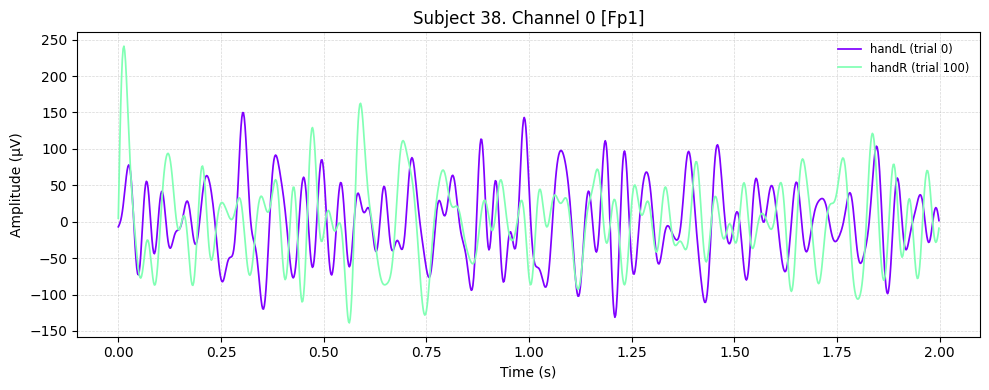

In [9]:
ds1_subject38.plot_channel(trial=0, channel=0)

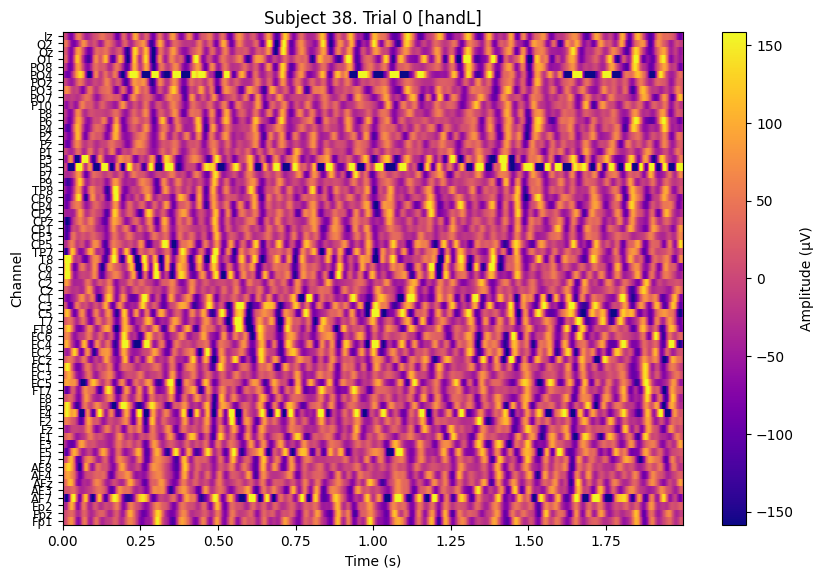

In [10]:
ds1_subject38.plot_trial_heatmap(trial=0)

## Dataset 4: The largest SCP data of Motor-Imagery
The dataset contains 60 hours of EEG BCI recordings across 75 recording sessions of 13 participants, 60,000 mental imageries, and 4 BCI interaction paradigms, with multiple recording sessions and paradigms of the same individuals. BCI interactions involving up to 6 mental imagery states are considered.

### DS4 File Contents

In [11]:
DATASET4_PATH = os.path.expanduser('~/data/BCI/4_EEG_6StatesMI')
print(DATASET4_PATH)
print(os.listdir(DATASET4_PATH)[:5])

/Users/anna/data/BCI/4_EEG_6StatesMI
['paper.pdf', '1Description.txt', 'HaLTSubjectB1602256StLRHandLegTongue.mat', 'HaLTSubjectB1602186StLRHandLegTongue.mat', 'HaLTSubjectA1603086StLRHandLegTongue.mat']


In [12]:
subject4_path = os.path.join(DATASET4_PATH, 'HaLTSubjectB1602186StLRHandLegTongue.mat')
mat_utils.print_top_level_keys(subject4_path)

['o']


In [13]:
mat_utils.print_key_info(subject4_path, 'o')

`o` keys: ['id', 'tag', 'sampFreq', 'nS', 'marker', 'data', 'chnames', 'binsuV']
id                   str             value=201602181925.D091BB44
tag                  str             value=NK-data import (auto)
sampFreq             int             value=200
nS                   int             value=666400
marker               ndarray         shape=(666400,) dtype=uint8
data                 ndarray         shape=(666400, 22) dtype=float64
chnames              ndarray         shape=(22,) dtype=object
binsuV               int             value=1


### DS4 Data Examples

In [14]:
ds4 = Dataset4(DATASET4_PATH)
ds4.print_info()

Total subjects: 5
Epoch window: 0.000–0.850 s
Total subject data: 130.46 MB


In [15]:
print(', '.join(ds4.subject_ids()))

A160223, A160308, A160310, B160218, B160225


In [16]:
ds4_subject = ds4.get_subject('A160223')
ds4_subject.print_info()

Subject ID: A160223
sampling_rate: 200, n_trials: 959, n_channels: 21, n_samples: 170
X: (959, 21, 170), Y: (959,)


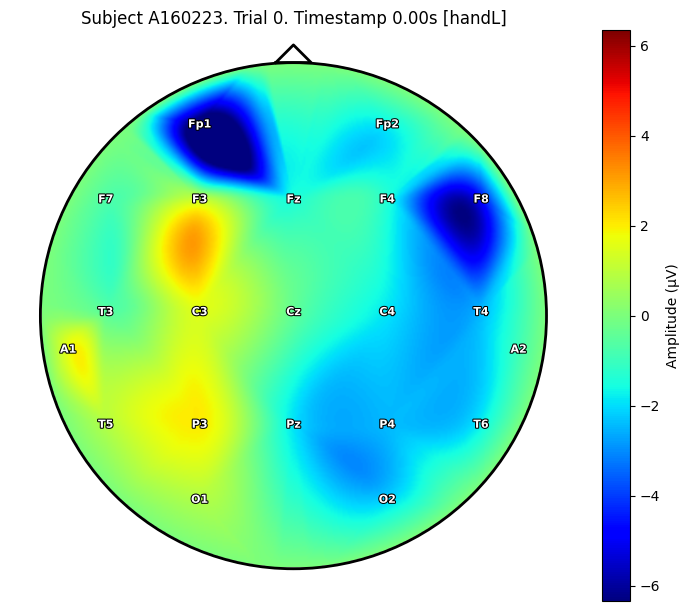

In [20]:
ds4_subject.plot_head(trial=0, plot_joint=False)

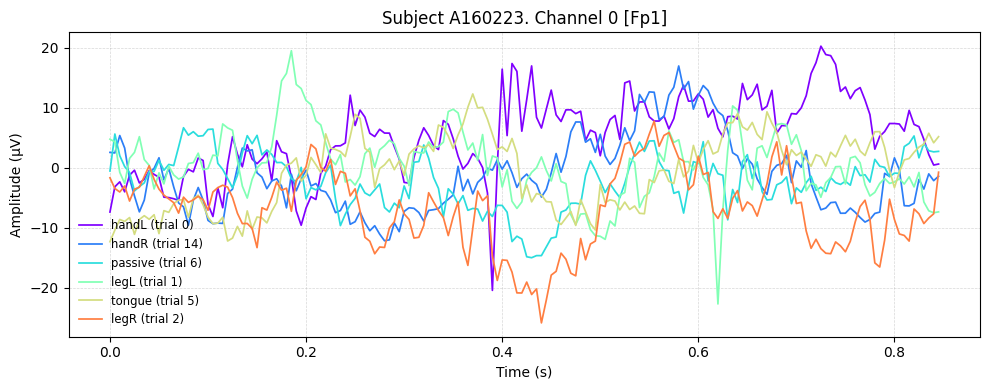

In [18]:
ds4_subject.plot_channel(trial=0, channel=0)

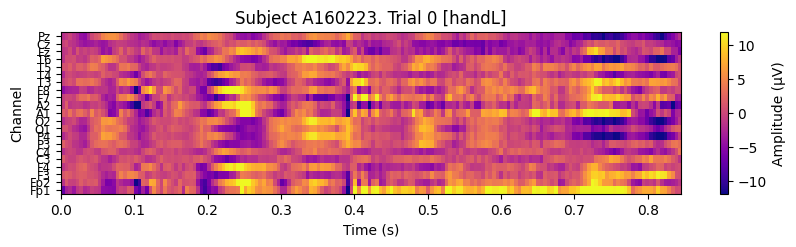

In [19]:
ds4_subject.plot_trial_heatmap(trial=0)

## Datset 8: High-Gamma Dataset
128-electrode dataset obtained from 14 healthy subjects with roughly 1000 four-second trials of executed movements divided into 13 runs per subject. The four classes of movements were movements of either the left hand, the right hand, both feet, and rest.

### DS8 File Contents

### DS8 Data Examples

## Classification

In [21]:
X, Y, groups = ds1.get_XY()
X.shape, Y.shape, groups.shape

((10520, 64, 1024), (10520,), (10520,))

In [21]:
X, Y, groups = ds4.get_XY()
X.shape, Y.shape, groups.shape

((4790, 21, 170), (4790,), (4790,))

### DS1 Baseline

In [22]:
results = baseline.evaluate_all_subjects(
    X, Y, groups, 
    fs=512, 
    n_repeats=120, 
    test_frac=0.30, 
    seed=42
)

s01: 80.61% ± 4.20%
s02: 48.07% ± 6.43%
s03: 93.19% ± 2.85%
s04: 86.33% ± 3.64%
s05: 75.89% ± 5.18%
s06: 82.64% ± 5.03%
s07: 51.05% ± 5.55%
s08: 47.57% ± 6.16%
s09: 67.81% ± 6.35%
s10: 75.53% ± 6.84%
s11: 59.24% ± 7.22%
s12: 67.39% ± 6.25%
s13: 60.46% ± 5.77%
s14: 96.94% ± 1.83%
s15: 76.31% ± 5.42%
s16: 51.71% ± 5.38%
s17: 46.40% ± 5.33%
s18: 58.68% ± 6.95%
s19: 57.03% ± 6.24%
s20: 68.36% ± 7.28%
s21: 71.58% ± 6.68%
s22: 60.03% ± 5.99%
s23: 85.22% ± 4.80%
s24: 65.67% ± 5.96%
s25: 67.32% ± 6.27%
s26: 64.93% ± 6.99%
s27: 56.31% ± 6.10%
s28: 59.56% ± 6.77%
s29: 46.94% ± 5.84%
s30: 61.28% ± 7.13%
s31: 67.10% ± 6.64%
s32: 53.87% ± 5.91%
s33: 62.86% ± 5.81%
s34: 53.79% ± 6.87%
s35: 78.82% ± 4.39%
s36: 67.61% ± 7.60%
s37: 62.75% ± 7.65%
s38: 50.65% ± 6.96%
s39: 63.88% ± 5.97%
s40: 52.79% ± 5.59%
s41: 89.25% ± 3.00%
s42: 58.13% ± 5.70%
s43: 96.56% ± 2.69%
s44: 68.28% ± 5.67%
s45: 54.44% ± 6.86%
s46: 80.13% ± 4.17%
s47: 61.93% ± 8.37%
s48: 82.22% ± 8.19%
s49: 75.01% ± 4.65%
s50: 83.19% ± 6.85%
